In [6]:
# en = args.encoder_layers
# de= args.decoder_layers
# random.seed(3000)
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf

dim=192
mgh = pathlib.Path('fetus_label_map')
mgh_files = list(mgh.glob('*.nii.gz'))
# label_maps = [np.uint8(sf.load_volume(str(file_path)).data) for file_path in mgh_files]
label_maps = [np.uint8(sf.load_volume(str(file_path)).reshape([dim,dim,dim]).data) for file_path in mgh_files]


labels = np.unique(label_maps)
in_shape = label_maps[0].shape


labels = np.unique(label_maps)
num_labels=8
# labels_in = range(max(labels) + num_labels + 1)
labels_in = np.unique(label_maps) # change this for feta

# feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_3d')
# feta_files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
# feta = pathlib.Path('feta_scaled')
# feta_files = list(feta.glob('*.nii.gz'))
# feta = pathlib.Path('feta_scaled_3')
# feta_files = list(feta.glob('*.nii.gz'))
feta = pathlib.Path('feta_resized_192')
feta_files = list(feta.glob('*.nii.gz'))
feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]

# feta_label_maps = [np.uint8(sf.load_volume(str(f)).data) for f in feta_files]

# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
print(len(feta_label_maps))

print(feta_label_maps[0].shape)

40
(192, 192, 192)


# Build New Dataset

In [7]:

# from scipy.ndimage import zoom
# def scale_down_brain(label_map, scale_factor=10):
#     scaled_label_map = zoom(label_map, 1/scale_factor, order=0, mode='constant', cval=0)
#     pad_amount = np.floor((np.array(label_map.shape) - np.array(scaled_label_map.shape)) / 2).astype(int)
#     padded_label_map = np.pad(scaled_label_map, (
#         (pad_amount[0], label_map.shape[0] - scaled_label_map.shape[0] - pad_amount[0]),
#         (pad_amount[1], label_map.shape[1] - scaled_label_map.shape[1] - pad_amount[1]),
#         (pad_amount[2], label_map.shape[2] - scaled_label_map.shape[2] - pad_amount[2])
#     ), mode='constant', constant_values=0)

#     return padded_label_map
    
# def shift_brain_to_center(label_map, center_coordinates):
#     original_center = np.array(label_map.shape) // 2
#     shift_amount = np.array(center_coordinates) - original_center

#     shifted_label_map = np.roll(label_map, shift_amount, axis=(0, 1, 2))
#     shifted_label_map[shift_amount[0]:, shift_amount[1]:, shift_amount[2]:] = 0  # Set background for the shifted region

#     return shifted_label_map
    
# def shift_brain_right(label_map, shift_amount=50):
#     shifted_label_map = np.roll(label_map, shift_amount, axis=2)
#     shifted_label_map[:, :, :shift_amount] = 0  # Set background for the shifted slices
#     return shifted_label_map
# ref=label_maps[0]  
# new_label_maps = []
# for i in range(len(feta_label_maps)):
#     fet = feta_label_maps[i]
#     # print(fet.shape)
#     fet = scale_down_brain(fet, scale_factor=3)
#     # fet=shift_brain_right(fet)
#     x,y,z = find_center_of_mass(ref)
#     # print(x,y,z)
#     fet = shift_brain_to_center(fet,[x,y,z])
#     # print(find_center_of_mass(fet))
#     new_label_maps.append(fet)
#     nib.save(nib.Nifti1Image(fet.astype(np.int32), np.eye(4), header=None), f"feta_scaled_3/sub_{i}.nii.gz")

# feta_label_maps=new_label_maps
#     # ne.plot.volume3D(fet, cmaps=['tab20c'])

In [8]:


from scipy.ndimage import binary_dilation, gaussian_filter
from scipy.ndimage import binary_dilation, binary_erosion, gaussian_filter
from skimage.morphology import ball

from scipy.ndimage import binary_dilation, binary_erosion
from skimage.morphology import ball

import numpy as np


from scipy.ndimage import center_of_mass

from scipy.ndimage import center_of_mass


import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass

import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass

import numpy as np
from scipy.ndimage import binary_dilation
from scipy.ndimage.measurements import center_of_mass



# def generate_random_label_maps_feta(brain_maps1, fov_maps):
#     return [
#         np.roll(
#             brain_maps1[selected_brain_index] + fov * (brain_maps1[selected_brain_index] == 0),
#             np.round(np.random.uniform(0.2, 0.8, size=2) * np.array(brain_maps1[selected_brain_index].shape[:2])) * np.random.choice([-1, 1], size=2),
#             axis=(0, 1)
#         )
#         for selected_brain_index, fov in zip(np.random.choice(len(brain_maps1), len(fov_maps)), fov_maps)
#     ]



    
    
from skimage import transform
import numpy as np

from scipy.ndimage import binary_dilation
from skimage.transform import rescale

# def scale_brain_maps(brain_maps, scale_factor):
#     target_shape = (256, 256, 256)
#     return [
#         np.pad(
#             rescale(b.astype(float), scale_factor, anti_aliasing=True, preserve_range=True).astype(int),
#             [(0, max(0, target_shape[i] - rescale(b.astype(float), scale_factor, anti_aliasing=True, preserve_range=True).shape[i])) for i in range(3)],
#             mode='constant'
#         )
#         for b in brain_maps
#     ]
    
# def get_fov(a, max_shift=60):
#     a_copy = np.copy(a)
#     best_directions = []
#     for i in range(len(a)):
#         b = a_copy[i]
#         m = (b >= 1) & (b < 8)
#         m = binary_dilation((m > 0), structure=np.ones((2, 2, 2)))

#         max_sum = 0
#         best_shift = 0
#         best_direction = 0

#         for d in range(3):
#             for shift in range(-max_shift, max_shift + 1):
#                 shifted_m = np.roll(m, shift, axis=d)
#                 current_sum = np.sum(b[shifted_m])

#                 if current_sum > max_sum:
#                     max_sum = current_sum
#                     best_shift = shift
#                     best_direction = d

#         shifted_m = np.roll(m, best_shift, axis=best_direction)
#         best_directions.append(best_direction)
#         b[m] = 0
#         b[m] = a_copy[i][shifted_m]
        
#         a_copy[i] = b

#     return a_copy , best_directions



# Show.
print(len(label_maps),np.max(label_maps[0]))
num_row = 2
per_row = 8

brain_maps = get_brain(label_maps)
fov_maps = get_fov(label_maps)


10 16


(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)


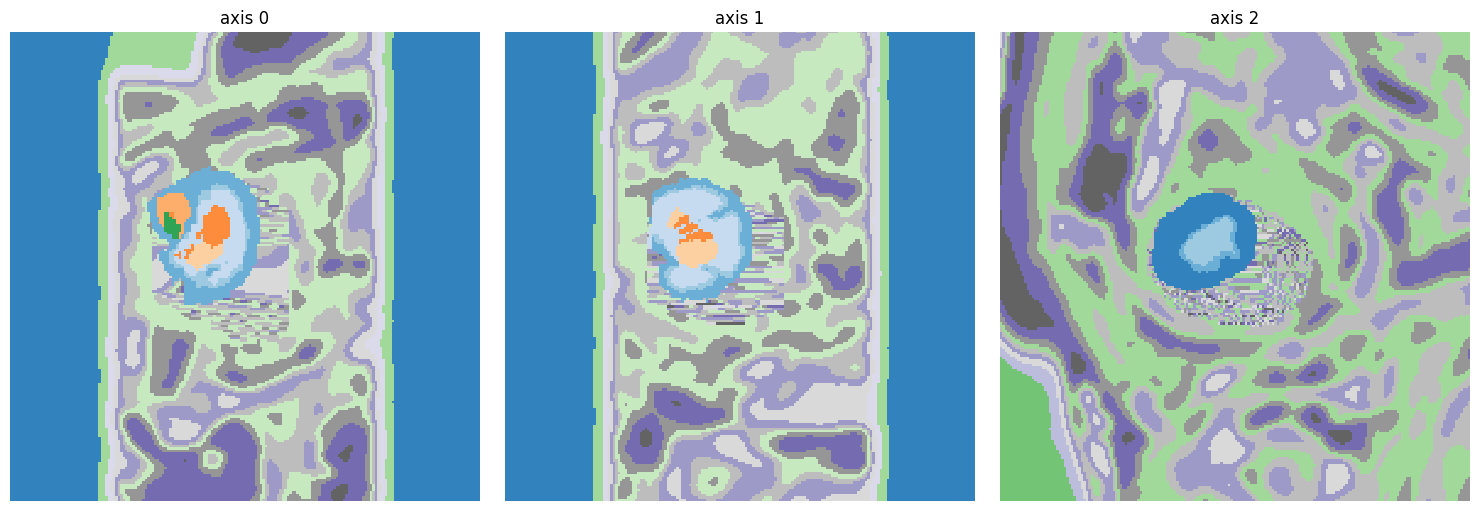

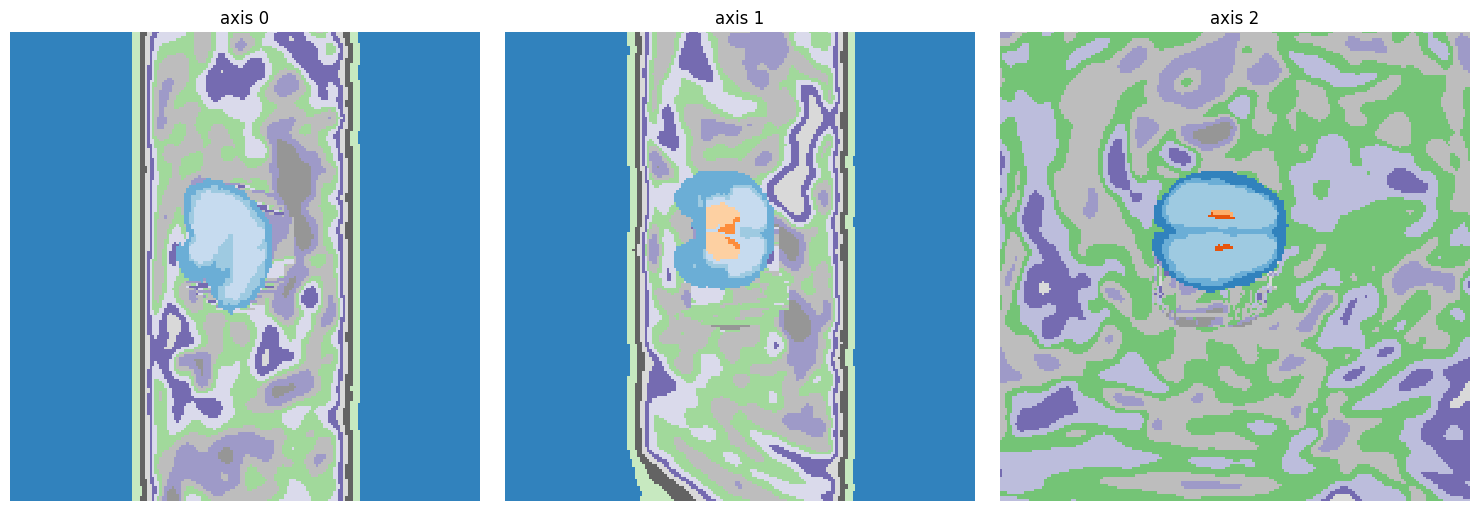

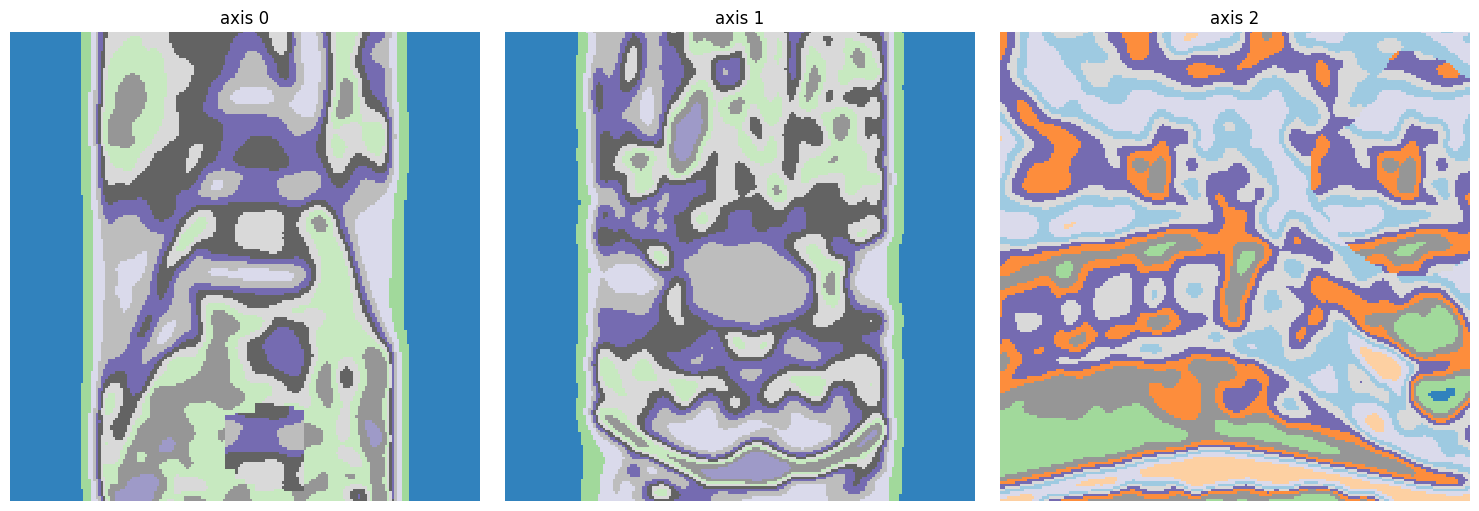

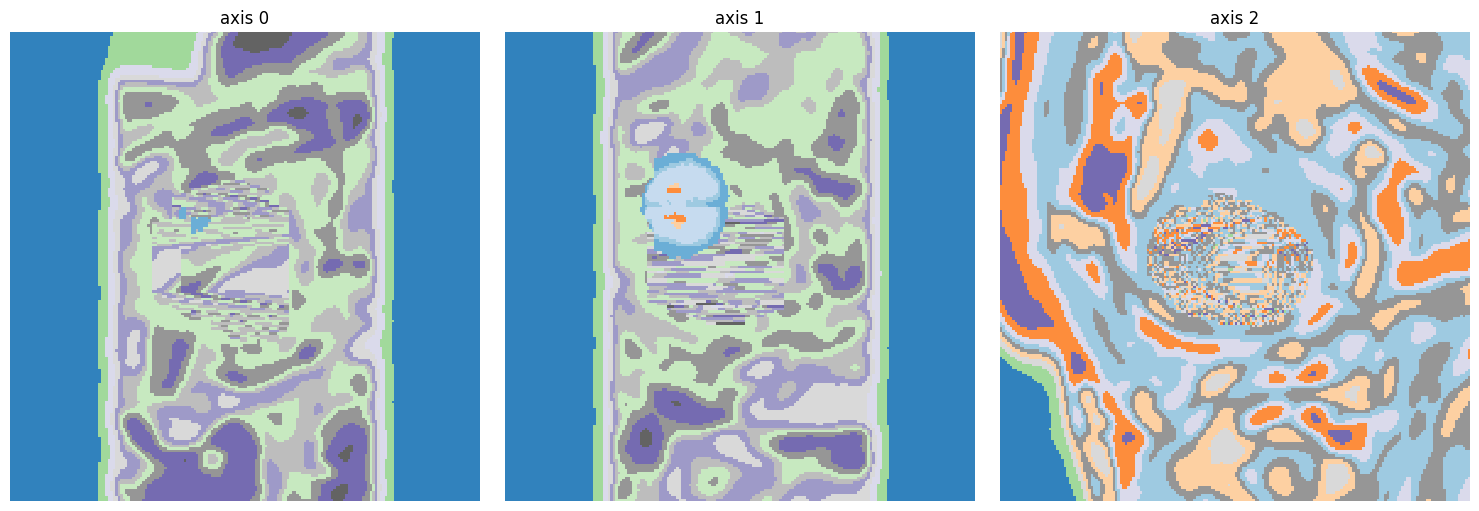

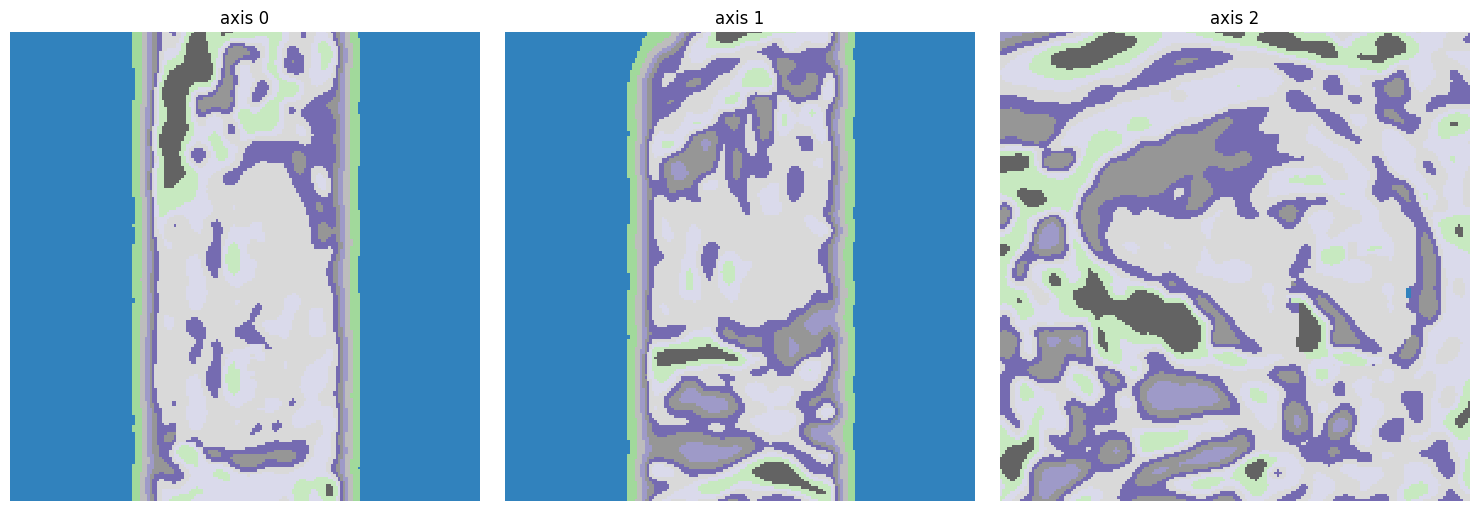

In [14]:
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation

def create_model(model_config):
    return ne.models.labels_to_image_new(**model_config)
    
import json

with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

model_feta_config = config["feta"]

# Convert labels_out keys to integers for all models
model1_config["labels_out"] = {int(key): value for key, value in model1_config["labels_out"].items()}
model2_config["labels_out"] = {int(key): value for key, value in model2_config["labels_out"].items()}
model_feta_config["labels_out"] = {int(key): value for key, value in model_feta_config["labels_out"].items()}


model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

# model4_config["labels_out"] = {int(key): value for key, value in model4_config["labels_out"].items()}
# Now you have the modified configuration
# Brain
model1 = create_model(model1_config)
# Body
model2 = create_model(model2_config)
# FeTA brain
model_feta = create_model(model_feta_config)

labels_to_image_model = create_model(model3_config)

# #brain
# model1 = ne.models.labels_to_image_new(
#     in_shape=in_shape,
#     labels_in=labels_in,
#     labels_out={i: i if i in (1, 2, 3, 4, 5, 6, 7) else 0 for i in labels_in},
#     warp_min=0.1,  # Adjust this value for a small warping change
#     warp_max=0.2,  # Adjust this value for a small warping change
#     one_hot=False,
#     aff_rotate=20,
#     aff_shift=0,
#     up_scale=False,
#     aff_scale=0.0

# )

# #body
# model2 = ne.models.labels_to_image_new(
#     in_shape=in_shape,
#     labels_in=labels_in,
#     labels_out={i: 0 if i in (1, 2, 3, 4, 5, 6, 7) else i for i in labels_in},
#     aff_rotate=5,
#     aff_shear=0.0,
#     aff_shift=1,
#     blur_max=1,
#     warp_min=0.1,  # Adjust this value for a small warping change
#     warp_max=1,  # Adjust this value for a small warping change
#     slice_prob=1,
#     one_hot=False,
#     crop_prob=1,
#     aff_scale=1

# )

# #both
# model3 = ne.models.labels_to_image_new(
#     in_shape=in_shape,
#     labels_in=labels_in,
#     labels_out={f: 1 if f in (1, 2, 3, 4, 5, 6, 7) else 0 for f in labels_in},
#     warp_min=0.01,  # Adjust this value for a small warping change
#     warp_max=2,  # Adjust this value for a small warping change
#     blur_max=1,
#     noise_min=0.0,
#     noise_max=0.1,
#     one_hot=True,
#     zero_background=0.2,
#     aff_scale=0.5,
#     mean_min=[0.2 if f in (1, 2, 3, 4, 5, 6, 7) else 0.0 for f in labels_in],
#     mean_max=[1.0 if f in (1, 2, 3, 4, 5, 6, 7) else 0.8 for f in labels_in]

# )

        
num_gen = 5
output_labels = []

for i in range(num_gen):

    gen = gen_brain_feta_fov(feta_label_maps, fov_maps)# model1, model2)
    output_label = next(gen)
    output_labels.append(output_label)
    nib.save(nib.Nifti1Image(np.squeeze(output_label, axis=(0, -1)).astype(np.int32), np.eye(4), header=None), f"samples/feta_label_map_{i}.nii.gz")
    ne.plot.volume3D(np.squeeze(output_label, axis=(0, -1)), cmaps=['tab20c'])

            


In [13]:
# print(output_brain.shape)
output_labels[0].shape

(1, 256, 256, 256, 1)

2024-03-01 22:34:59.292507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


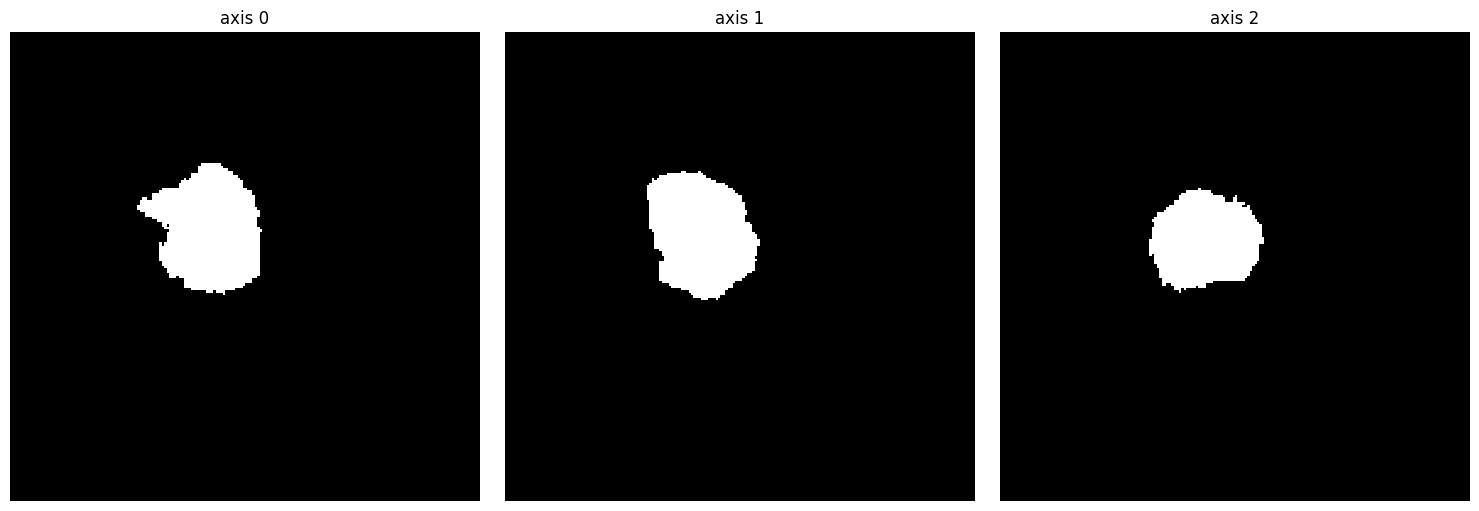

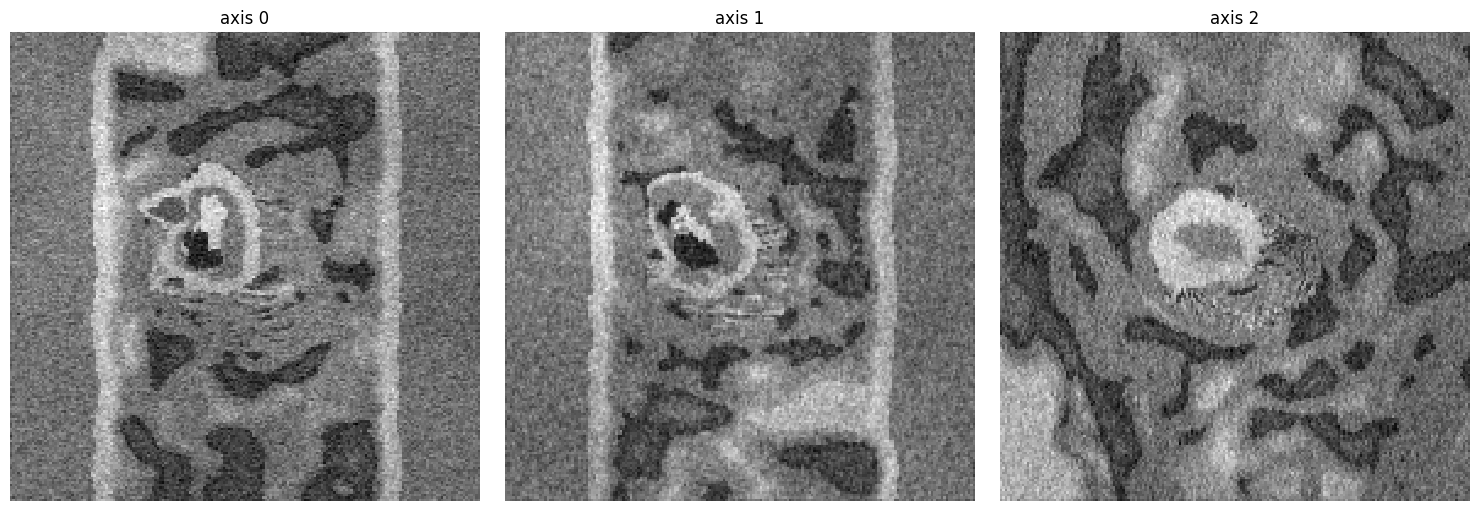

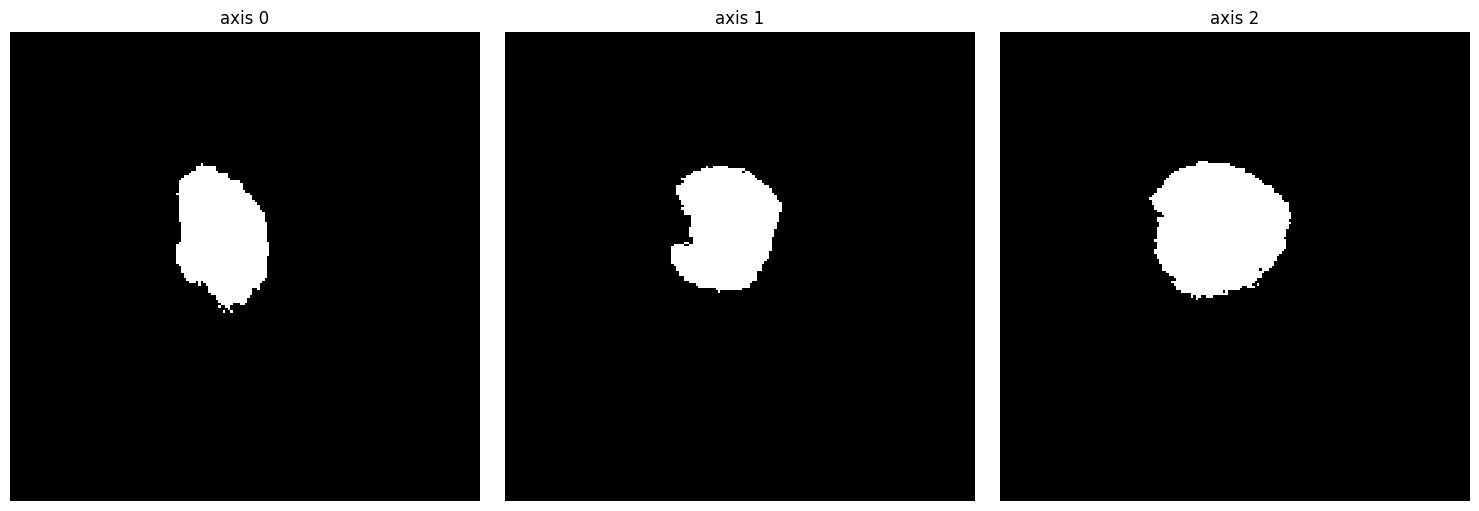

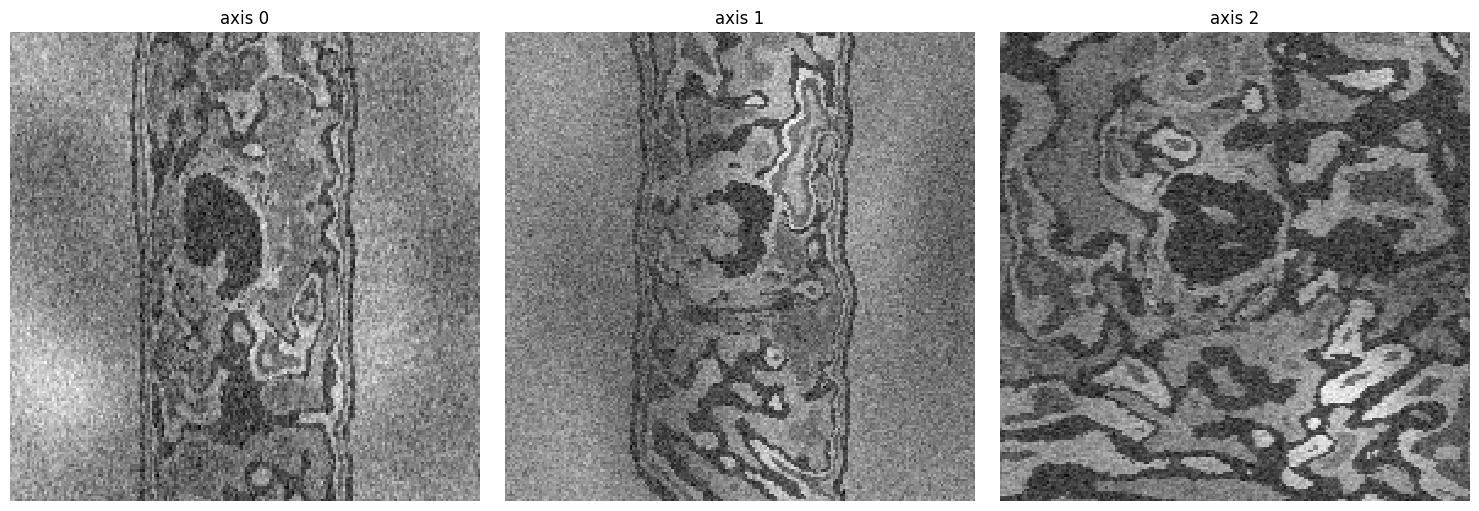

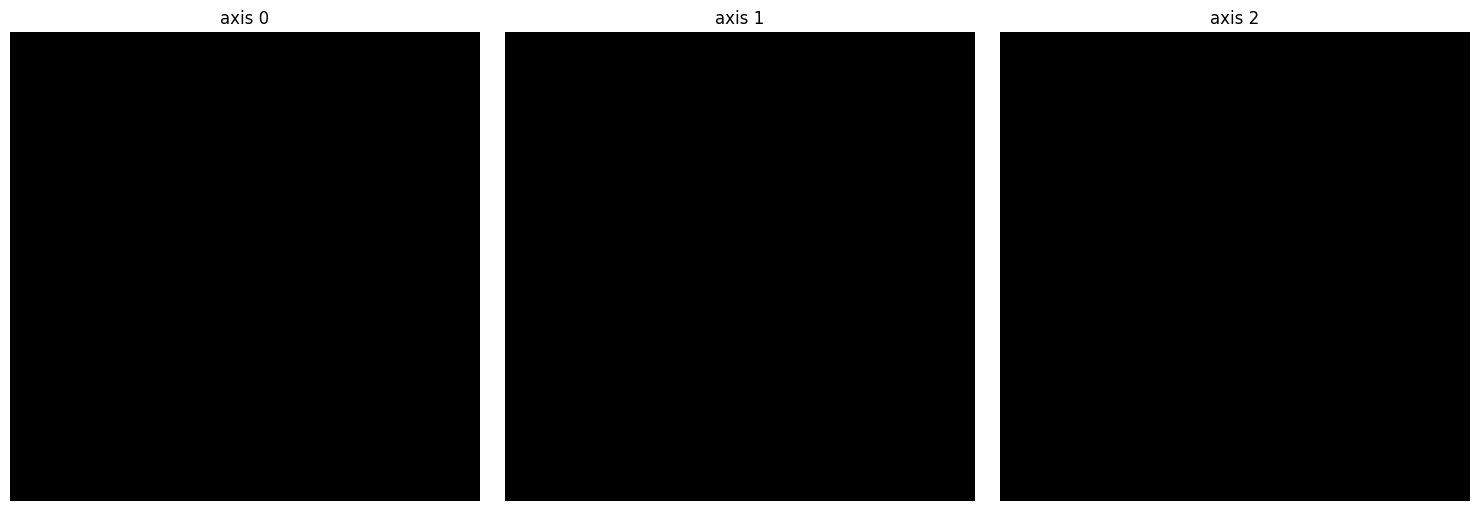

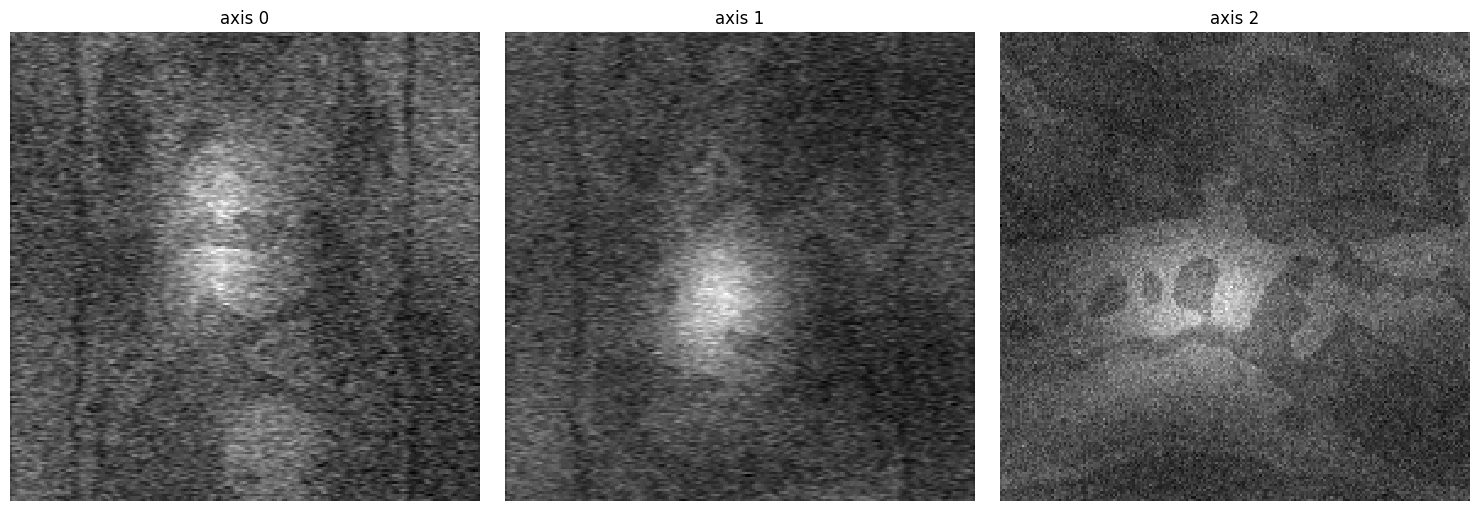

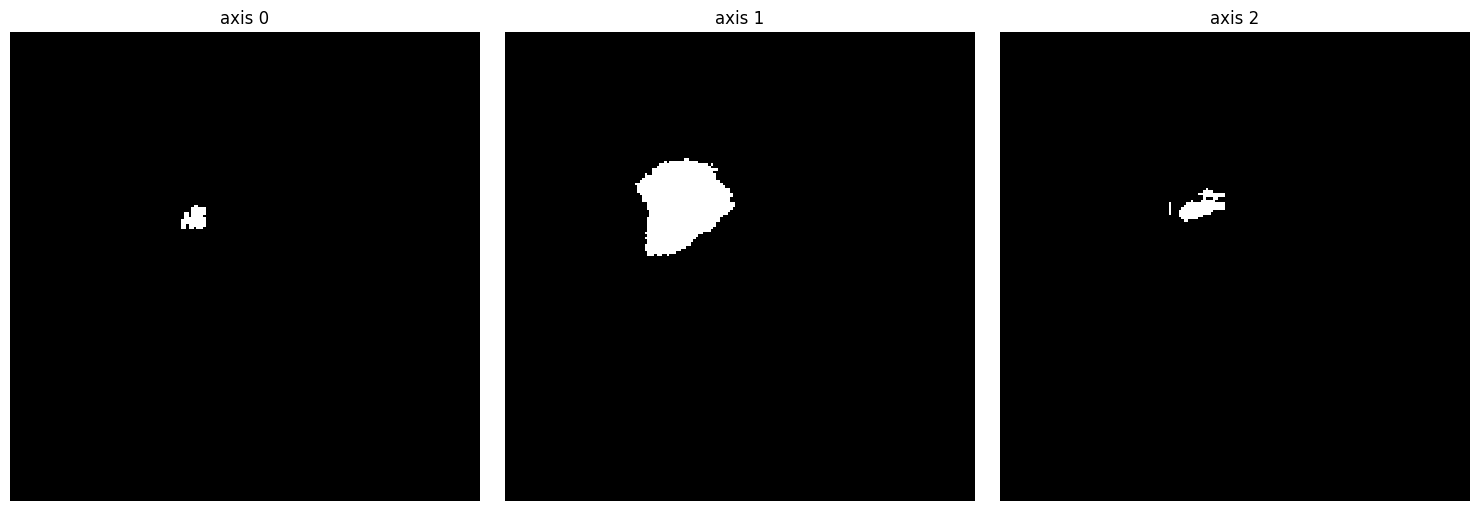

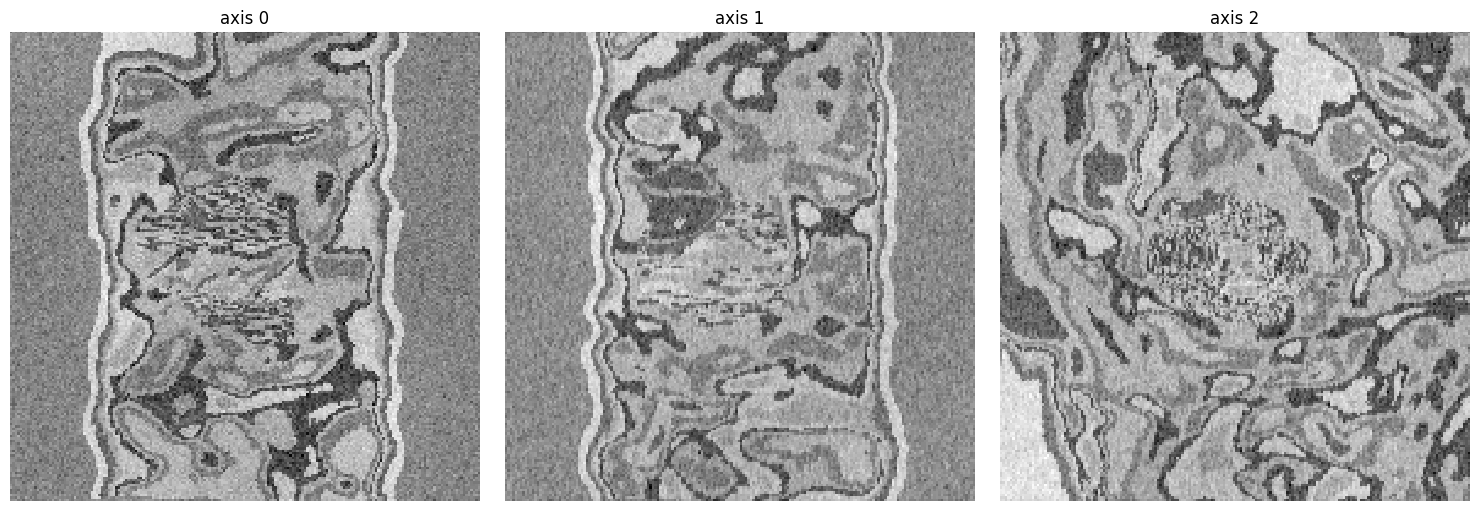

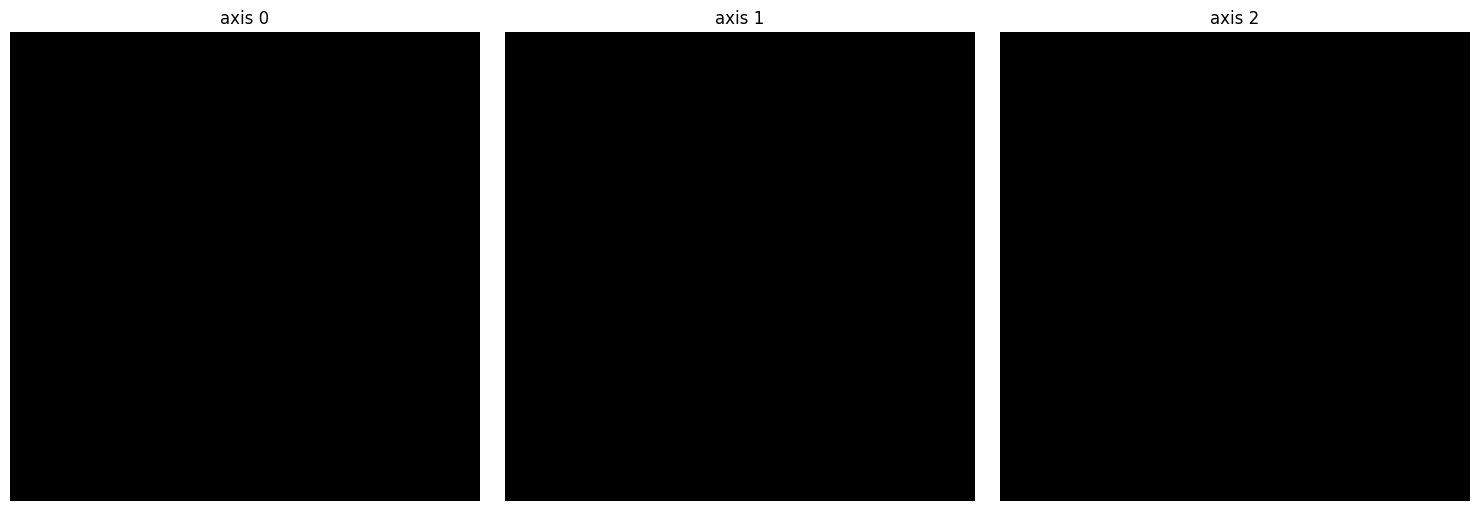

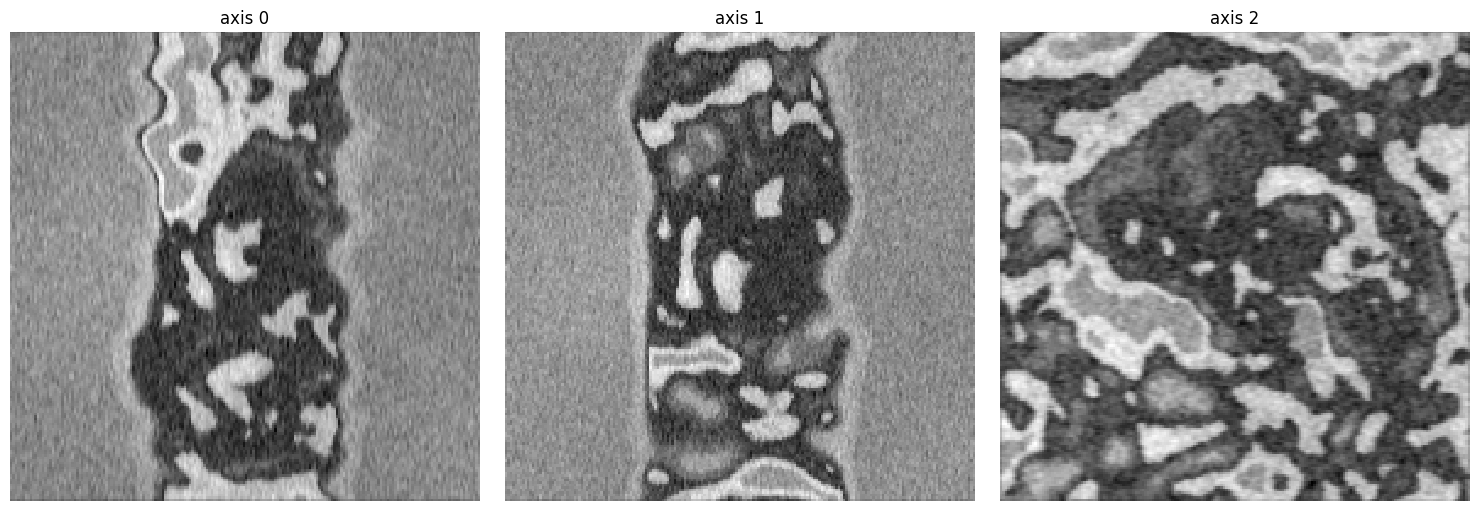

In [15]:
images = []
one_hots = []
for i in range(num_gen):
    im, oh = zip(*[labels_to_image_model.predict(output_labels[i], verbose=0) for _ in range(1)])
    nib.save(nib.Nifti1Image(np.squeeze(im[0], axis=(0, -1)), np.eye(4)), f"samples/feta_mgh{i}.nii.gz")
    nib.save(nib.Nifti1Image(np.argmax(oh[0],axis=-1).squeeze(axis=0).astype(np.int32), np.eye(4)), f"samples/feta_mask_mgh{i}.nii.gz")
    ne.plot.volume3D(np.argmax(oh[0],axis=-1))
    # ne.plot.volume3D(np.argmax(oh[0],axis=-1))
    ne.plot.volume3D(im)

In [7]:
output_label.shape

(1, 256, 256, 256, 1)